In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
%matplotlib inline
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

DATA_PATH = './data/'
DATA_SET_CSV = 'dataset.csv'

#csv파일 읽기
dataset = pd.read_csv(DATA_PATH+DATA_SET_CSV)
codes = list(dataset['code'])
y = np.array(dataset['sentiment'])

#csv파일 제대로 읽었는지 확인
print(np.count_nonzero(y == 0))
print(np.count_nonzero(y == 1))


14516
1002


In [2]:
#특징을 5000개로 잡았다면 
#빈도 높은거 5000개로 추림
#이게 인덱스를 단어 오름차순으로 붙이는거 같다
#카운트벡터는 _는 가능한데 -나 .는 분리하는 거 같다 -> 정규 표헌식 사용
def count_vectorizer(features):
    vector = CountVectorizer(max_features = features, ngram_range = (1,2), token_pattern = "[a-z0-9-._:]+") 
    vector_dataset = vector.fit_transform(codes)
    '''words =[]
    for word, index in vector.vocabulary_.items():
        if word in ":":
            print(index , ":", word)
        words.append(word)
    words.sort()'''
    return vector, vector_dataset


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
#TF-IDF 
def Tf_idf(features):
    vector = TfidfVectorizer(min_df = 1,ngram_range = (1,2), max_features = features, sublinear_tf=True, token_pattern = "[a-zA-Z0-9-._:]+")
    vector_dataset = vector.fit_transform(codes)
    return vector, vector_dataset

In [4]:
from sklearn.model_selection import GridSearchCV
#랜덤 포레스트 최적의 하이퍼 파라미터 구하기
params = {
    'n_estimators' : [100,150,200],
    'max_depth' : [6,8,10,12,15],
    'min_samples_leaf' : [3,5, 8, 10],
    'min_samples_split' : [3,5, 8, 10]
    
}
#n_jobs = -1 -> 모든 CPU 코어 사용 random_state=0,
vector, vector_dataset = count_vectorizer(4000)
x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state = 42)
tuning_forest = RandomForestClassifier(n_jobs = -1) 
grid = GridSearchCV(tuning_forest, param_grid = params, cv = skf, n_jobs = -1)
grid.fit(x_train, y_train)
print("최적 :", grid.best_params_)
print("최고 정확도 :", grid.best_score_)

최적 : {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
최고 정확도 : 0.9788251772578924


In [5]:
#XGB 최적의 하이퍼 파라미터 구하기
params = {
    'n_estimators' : [100,150,200],
    'learning_rate' : [0.04,0.08,0.1,0.2],
    'max_depth' : [6,8,10,12,15]
}
#vector, vector_dataset =  count_vectorizer(4000)
#x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.3, random_state = 42, stratify = y)
tuning_gradient = XGBClassifier()
grid = GridSearchCV(tuning_gradient, param_grid = params, cv = skf)
grid.fit(x_train, y_train)
print("최적 :", grid.best_params_)
print("최고 정확도 :", grid.best_score_)

최적 : {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 150}
최고 정확도 : 0.9888603058788945


In [6]:
#GBM 최적의 하이퍼 파라미터 구하기
params = {
    'n_estimators' : [100,150,200],
    'learning_rate' : [0.04,0.06,0.08,0.1]
}
#vector, vector_dataset =  count_vectorizer(4000)
#x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)
tuning_gradient = GradientBoostingClassifier()
grid = GridSearchCV(tuning_gradient, param_grid = params, cv = skf)
grid.fit(x_train, y_train)
print("최적 :", grid.best_params_)
print("최고 정확도 :", grid.best_score_)

최적 : {'learning_rate': 0.04, 'n_estimators': 100}
최고 정확도 : 0.9866507425733761


In [7]:
#adaboost 최적의 하이퍼 파라미터 구하기
params = {
    'n_estimators' : [100,150,200, 250, 300],
}
#vector, vector_dataset = count_vectorizer(4000)
#x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)
tuning_ada = AdaBoostClassifier(random_state=0)
grid = GridSearchCV(tuning_ada, param_grid = params, cv = skf)
grid.fit(x_train, y_train)
print("최적 :", grid.best_params_)
print("최고 정확도 :", grid.best_score_)

최적 : {'n_estimators': 300}
최고 정확도 : 0.9872032287612216


In [8]:
index = [100,500,1000,2000,3000, 4000, 5000]
def draw_table(name, accuracy, precision, recall, F1,auc):
    raw_data = {'accuracy' : accuracy, 'precision':precision, 'recall':recall,'F1':F1,'auc':auc}
    table = pd.DataFrame(raw_data)
    table.index = name
    print(table)
    
def draw_table1(name, accuracy, precision, recall, F1):
    raw_data = {'accuracy' : accuracy, 'precision':precision, 'recall':recall,'F1':F1}
    table = pd.DataFrame(raw_data)
    table.index = name
    print(table)

In [10]:
#카운트 벡터라이저 사용
accuracy = []
precision = [] 
recall = []
F1 = []
name = []
prob = []
#vector, vector_dataset = count_vectorizer(4000)
x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)
forest = RandomForestClassifier(n_estimators = 100, max_depth=15,min_samples_split=10,min_samples_leaf=3)
gradient = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.04)
ada = AdaBoostClassifier(n_estimators = 300)
xgb = XGBClassifier(n_estimators = 150, learning_rate = 0.2, max_depth=8)

for model in (forest, gradient, ada,xgb):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    prob.append(model.predict_proba(x_test))
    name.append(model.__class__.__name__)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    F1.append(f1_score(y_test, y_pred))
draw_table1(name, accuracy, precision, recall, F1)
    

                            accuracy  precision  recall        F1
RandomForestClassifier      0.978737   1.000000    0.67  0.802395
GradientBoostingClassifier  0.986469   0.987654    0.80  0.883978
AdaBoostClassifier          0.984536   0.922222    0.83  0.873684
XGBClassifier               0.988402   0.976744    0.84  0.903226


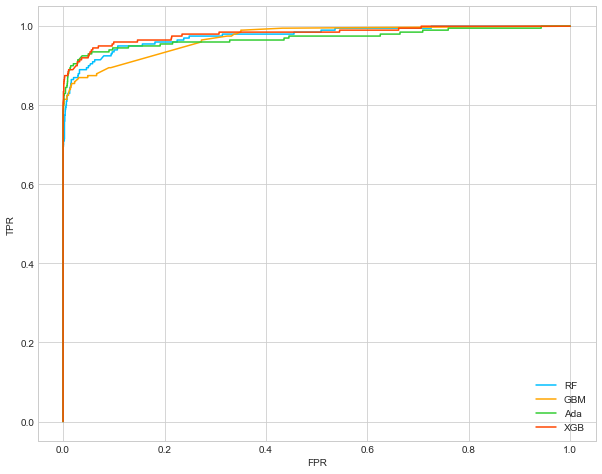

In [11]:
#GBM, ada, random forest, XGB ROC 곡선을 구해보자
fpr0, tpr0, thresholds0 = roc_curve(y_test, prob[0][:,1])
fpr1, tpr1, thresholds1 = roc_curve(y_test, prob[1][:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, prob[2][:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, prob[3][:,1])
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,8))
plt.plot(fpr0, tpr0, color = 'deepskyblue', label = 'RF')
plt.plot(fpr1, tpr1, color = 'orange', label = 'GBM')
plt.plot(fpr2, tpr2, color = 'limegreen', label = 'Ada')
plt.plot(fpr3, tpr3, color = 'orangered', label = 'XGB')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [12]:
print("RF:",roc_auc_score(y_test, prob[0][:,1]))
print("GBM:",roc_auc_score(y_test, prob[1][:,1]))
print("Ada:",roc_auc_score(y_test, prob[2][:,1]))
print("XGB:",roc_auc_score(y_test, prob[3][:,1]))

RF: 0.9756112258953168
GBM: 0.9701704545454546
Ada: 0.9698734504132231
XGB: 0.9810890151515151


In [76]:
#tf-idf사용
accuracy = []
precision = [] 
recall = []
F1 = []
name = []
prob = []
vector, vector_dataset = count_vectorizer(4000)
x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)
forest = RandomForestClassifier(n_estimators = 100)
gradient = GradientBoostingClassifier(n_estimators = 100)
ada = AdaBoostClassifier(n_estimators = 100)
xgb = XGBClassifier(n_estimators = 100)
for model in (forest, gradient, ada, xgb):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    prob.append(model.predict_proba(x_test))
    name.append(model.__class__.__name__)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    F1.append(f1_score(y_test, y_pred))
draw_table1(name, accuracy, precision, recall, F1)
    

                            accuracy  precision  recall        F1
RandomForestClassifier      0.986147   0.981595   0.800  0.881543
GradientBoostingClassifier  0.986147   0.953757   0.825  0.884718
AdaBoostClassifier          0.983570   0.907104   0.830  0.866841
XGBClassifier               0.988080   0.971098   0.840  0.900804


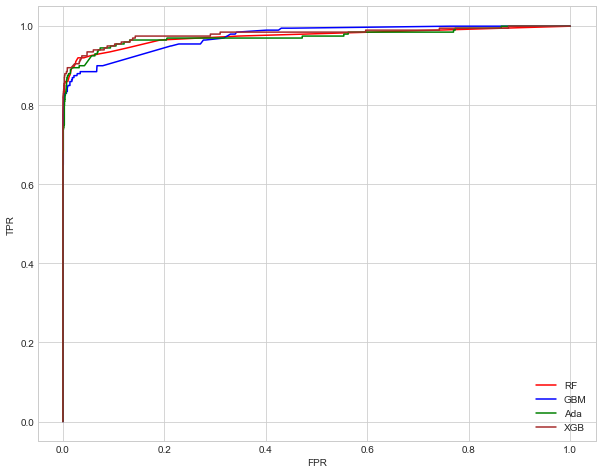

In [77]:
#GBM, ada, random forest, XGB ROC 곡선을 구해보자
fpr0, tpr0, thresholds0 = roc_curve(y_test, prob[0][:,1])
fpr1, tpr1, thresholds1 = roc_curve(y_test, prob[1][:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, prob[2][:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, prob[3][:,1])
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,8))
plt.plot(fpr0, tpr0, color = 'C0', label = 'RF')
plt.plot(fpr1, tpr1, color = 'C1', label = 'GBM')
plt.plot(fpr2, tpr2, color = 'C2', label = 'Ada')
plt.plot(fpr3, tpr3, color = 'C3', label = 'XGB')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [78]:
print("RF:",roc_auc_score(y_test, prob[0][:,1]))
print("GBM:",roc_auc_score(y_test, prob[1][:,1]))
print("Ada:",roc_auc_score(y_test, prob[2][:,1]))
print("XGB:",roc_auc_score(y_test, prob[3][:,1]))

RF: 0.9739962121212121
GBM: 0.9731069214876034
Ada: 0.973073347107438
XGB: 0.9800215220385674


In [9]:
def random_forest():
    accuracy = []
    precision = [] 
    recall = []
    F1 = []
    auc = []
    for i in index:
        vector, vector_dataset = count_vectorizer(i)
        x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)
        forest = RandomForestClassifier(n_estimators = 100)
        forest.fit(x_train, y_train)
        y_pred = forest.predict(x_test)
        prob = forest.predict_proba(x_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        F1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, prob[:,1]))
    draw_table(index,accuracy, precision, recall, F1,auc)

random_forest()

      accuracy  precision  recall        F1       auc
100   0.982603   0.934524   0.785  0.853261  0.968876
500   0.986147   0.981595   0.800  0.881543  0.978444
1000  0.985503   0.969697   0.800  0.876712  0.977429
1500  0.986147   0.975758   0.805  0.882192  0.978857
2000  0.986147   0.975758   0.805  0.882192  0.982181
2500  0.986469   0.981707   0.805  0.884615  0.978656
3000  0.987113   0.987805   0.810  0.890110  0.985509
3500  0.986791   0.981818   0.810  0.887671  0.970785
4000  0.986791   0.981818   0.810  0.887671  0.976050
4500  0.986791   0.981818   0.810  0.887671  0.977268
5000  0.986469   0.987654   0.800  0.883978  0.979650


In [13]:
def ada_model():
    accuracy = []
    precision = [] 
    recall = []
    F1 = []
    auc = []
    for i in index:
        vector, vector_dataset = count_vectorizer(i)
        x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)
        ada = AdaBoostClassifier(n_estimators = 100)
        ada.fit(x_train, y_train)
        y_pred = ada.predict(x_test)
        prob = ada.predict_proba(x_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        F1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, prob[:,1]))
    draw_table(index,accuracy, precision, recall, F1,auc)

ada_model()

      accuracy  precision    recall        F1       auc
100   0.972947   0.823204  0.741294  0.780105  0.960890
500   0.982287   0.924419  0.791045  0.852547  0.974335
1000  0.983575   0.926136  0.810945  0.864721  0.973643
1500  0.983253   0.916201  0.815920  0.863158  0.965799
2000  0.984219   0.922222  0.825871  0.871391  0.975054
2500  0.984219   0.926966  0.820896  0.870712  0.974801
3000  0.984863   0.923077  0.835821  0.877285  0.965283
3500  0.984219   0.926966  0.820896  0.870712  0.974839
4000  0.984541   0.927374  0.825871  0.873684  0.976190
4500  0.984863   0.927778  0.830846  0.876640  0.979074
5000  0.984541   0.927374  0.825871  0.873684  0.984801


In [14]:
def gbm_model():
    accuracy = []
    precision = [] 
    recall = []
    F1 = []
    auc = []
    for i in index:
        vector, vector_dataset = count_vectorizer(i)
        x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)
        gradient = GradientBoostingClassifier(n_estimators = 100)
        gradient.fit(x_train, y_train)
        y_pred = gradient.predict(x_test)
        prob = gradient.predict_proba(x_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        F1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, prob[:,1]))
    draw_table(index,accuracy, precision, recall, F1,auc)

gbm_model()

      accuracy  precision    recall        F1       auc
100   0.976490   0.900000  0.716418  0.797784  0.967353
500   0.982287   0.939759  0.776119  0.850136  0.975392
1000  0.982931   0.935294  0.791045  0.857143  0.969042
1500  0.983575   0.951807  0.786070  0.861035  0.969168
2000  0.983897   0.946746  0.796020  0.864865  0.969318
2500  0.982931   0.930233  0.796020  0.857909  0.966743
3000  0.984541   0.969325  0.786070  0.868132  0.967380
3500  0.984863   0.963855  0.796020  0.871935  0.968232
4000  0.984863   0.963855  0.796020  0.871935  0.968188
4500  0.985507   0.975610  0.796020  0.876712  0.967985
5000  0.984219   0.952381  0.796020  0.867209  0.967872


In [25]:
def xgb_model():
    accuracy = []
    precision = [] 
    recall = []
    F1 = []
    auc = []
    for i in index:
        vector, vector_dataset = count_vectorizer(i)
        x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)
        xgb = XGBClassifier(n_estimators = 200, learning_rate = 0.1)
        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)
        prob = xgb.predict_proba(x_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        F1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, prob[:,1]))
    draw_table(index,accuracy, precision, recall, F1,auc)

xgb_model()

      accuracy  precision    recall        F1       auc
100   0.981320   0.938650  0.761194  0.840659  0.973421
500   0.985507   0.964286  0.805970  0.878049  0.981402
1000  0.986795   0.976190  0.815920  0.888889  0.979953
1500  0.986795   0.976190  0.815920  0.888889  0.980874
2000  0.987762   0.988024  0.820896  0.896739  0.982126
2500  0.988406   0.988166  0.830846  0.902703  0.983298
3000  0.987440   0.993902  0.810945  0.893151  0.981386
3500  0.987762   0.993939  0.815920  0.896175  0.982829
4000  0.988084   0.982353  0.830846  0.900270  0.982434
4500  0.988406   0.988166  0.830846  0.902703  0.982079
5000  0.988406   0.994012  0.825871  0.902174  0.983729


Class=0, n=11612개 (50.0%)
Class=1, n=11612개 (50.0%)


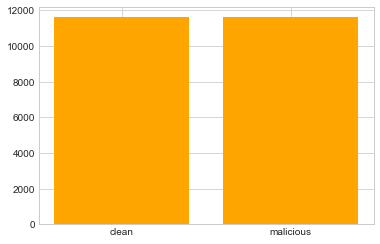

In [18]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter

#SMOTE로 오버샘플링하기   
def show_oversampling(y): 
    counter = Counter(y)
    index = ['clean', 'malicious']
    for k,v in counter.items():
        print('Class=%d, n=%d개 (%.1f%%)' % (k, v, v / len(y) * 100))
    plt.bar(index, counter.values(), color = "orange")
    plt.show()

vector, vector_dataset = count_vectorizer(4000)
x_train, x_test, y_train, y_test = train_test_split(vector_dataset, y, test_size = 0.2, random_state = 42, stratify = y)

sm = SMOTE(random_state = 1)

X_resampled, y_resampled = sm.fit_resample(x_train,list(y_train))
show_oversampling(y_resampled)